In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model

# Parameters
latent_dim = 2
input_shape = (28, 28, 1)
batch_size = 128
epochs = 30

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
def build_encoder():
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = layers.Lambda(sampling)([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
def build_decoder():
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return Model(latent_inputs, outputs, name="decoder")

# VAE subclassed model
class VAE(Model):
    def __init__(self, encoder, decoder, reconstruction_loss_type='bce', **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss_type = reconstruction_loss_type
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss
            if self.reconstruction_loss_type == 'bce':
                reconstruction_loss = tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=[1, 2, 3]
                )
            elif self.reconstruction_loss_type == 'mse':
                reconstruction_loss = tf.reduce_sum(
                    tf.keras.losses.mse(data, reconstruction), axis=[1, 2, 3]
                )
            else:
                raise ValueError("reconstruction_loss_type must be 'bce' or 'mse'")
            
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# Load MNIST data
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Build encoder and decoder
encoder = build_encoder()
decoder = build_decoder()

# Instantiate and compile two VAEs: one with BCE and one with MSE
vae_bce = VAE(encoder, decoder, reconstruction_loss_type='bce')
vae_bce.compile(optimizer='adam')

vae_mse = VAE(encoder, decoder, reconstruction_loss_type='mse')
vae_mse.compile(optimizer='adam')

# Train BCE VAE
print("Training VAE with BCE loss:")
history_bce = vae_bce.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None), verbose=2)

# Train MSE VAE
print("\nTraining VAE with MSE loss:")
history_mse = vae_mse.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None), verbose=2)

# Plot training loss curves
plt.plot(history_bce.history['loss'], label='BCE Train Loss')
plt.plot(history_bce.history['val_loss'], label='BCE Val Loss')
plt.plot(history_mse.history['loss'], label='MSE Train Loss')
plt.plot(history_mse.history['val_loss'], label='MSE Val Loss')
plt.title("Training Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualize reconstructions
def plot_reconstructions(model, data, n=10, title="Reconstruction"):
    preds = model.predict(data[:n])
    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title("Original")
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(preds[i].squeeze(), cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title(title)
    plt.show()

print("VAE with BCE reconstruction:")
plot_reconstructions(vae_bce, x_test, title="BCE Reconstruction")

print("VAE with MSE reconstruction:")
plot_reconstructions(vae_mse, x_test, title="MSE Reconstruction")


Training VAE with BCE loss:
Epoch 1/30


2025-07-22 18:55:23.167731: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


ValueError: Invalid reduction dimension 3 for input with 3 dimensions. for '{{node Sum}} = Sum[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false](Mean, Sum/reduction_indices)' with input shapes: [?,28,28], [3] and with computed input tensors: input[1] = <1 2 3>.

Training with BCE loss...
Epoch 1, Loss: 163.9051
Epoch 2, Loss: 121.2852
Epoch 3, Loss: 114.6646
Epoch 4, Loss: 111.7281
Epoch 5, Loss: 109.9645
Epoch 6, Loss: 108.7651
Epoch 7, Loss: 107.9252
Epoch 8, Loss: 107.3193
Epoch 9, Loss: 106.8142
Epoch 10, Loss: 106.4086
Training with MSE loss...
Epoch 1, Loss: 45.3318
Epoch 2, Loss: 35.2325
Epoch 3, Loss: 33.3107
Epoch 4, Loss: 32.3581
Epoch 5, Loss: 31.8044
Epoch 6, Loss: 31.4457
Epoch 7, Loss: 31.1859
Epoch 8, Loss: 30.9686
Epoch 9, Loss: 30.8059
Epoch 10, Loss: 30.6565


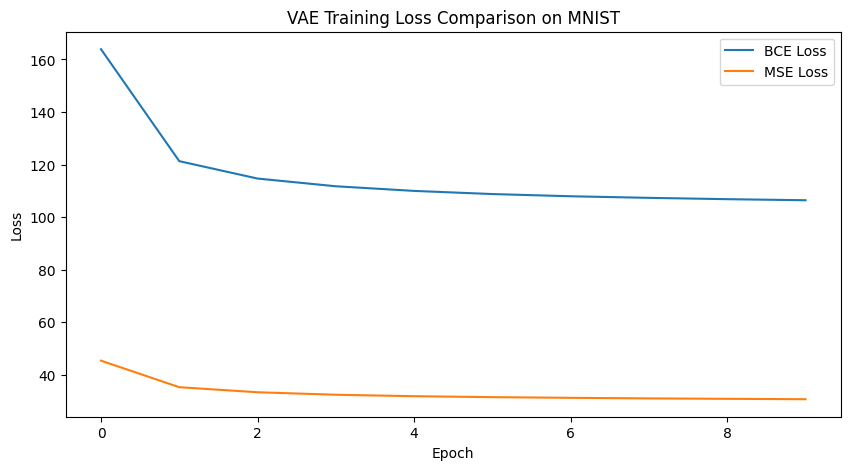

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data: MNIST normalized to [0,1]
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # mean
        self.fc22 = nn.Linear(400, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Functions
def loss_function_bce(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def loss_function_mse(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Training Loop
def train(model, train_loader, optimizer, loss_func, epochs=10):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            loss = loss_func(recon_x, x, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        avg_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
    return train_losses

# Instantiate model, optimizer
latent_dim = 20
model_bce = VAE(latent_dim).to(device)
optimizer_bce = optim.Adam(model_bce.parameters(), lr=1e-3)
model_mse = VAE(latent_dim).to(device)
optimizer_mse = optim.Adam(model_mse.parameters(), lr=1e-3)

# Train with BCE loss
print("Training with BCE loss...")
losses_bce = train(model_bce, train_loader, optimizer_bce, loss_function_bce, epochs=10)

# Train with MSE loss
print("Training with MSE loss...")
losses_mse = train(model_mse, train_loader, optimizer_mse, loss_function_mse, epochs=10)

# Plot training losses
plt.figure(figsize=(10,5))
plt.plot(losses_bce, label='BCE Loss')
plt.plot(losses_mse, label='MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss Comparison on MNIST')
plt.legend()
plt.show()


BCE VAE Reconstruction:


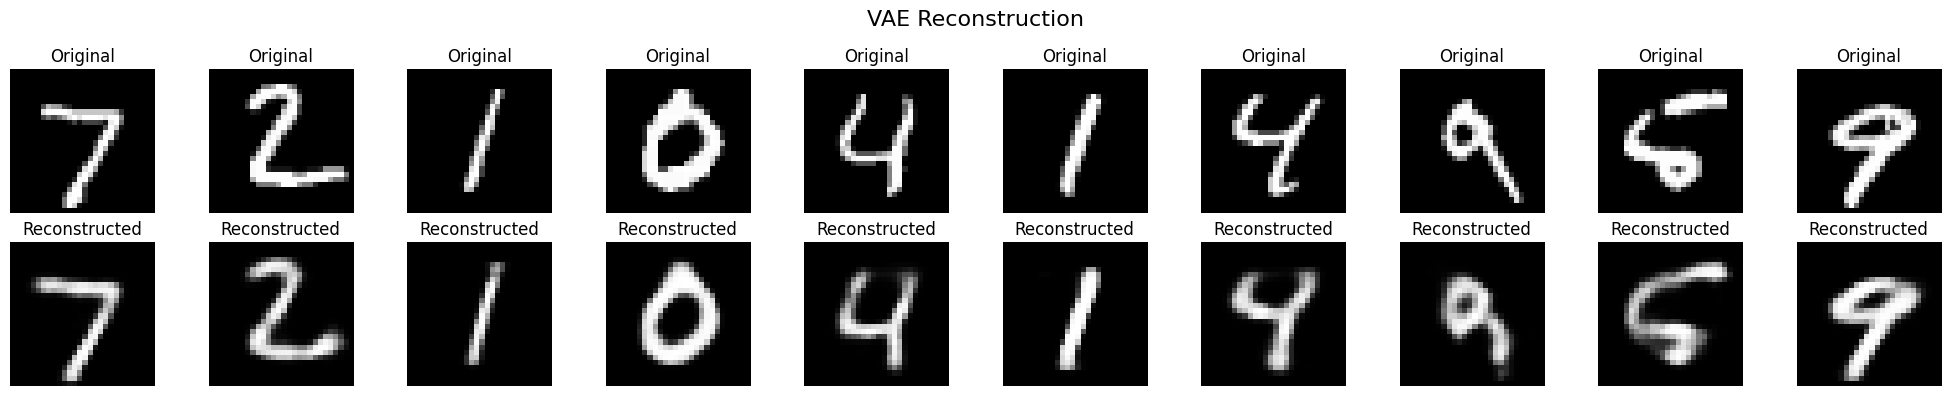

MSE VAE Reconstruction:


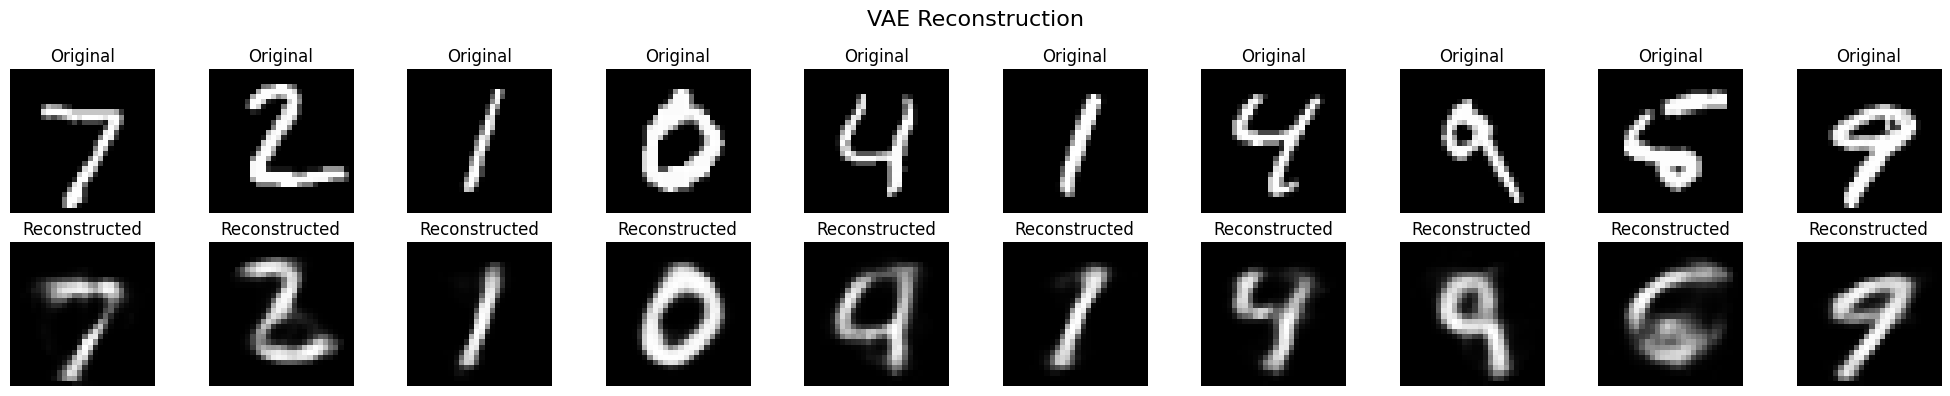

In [2]:
# ===== 1. FUNCTION: Plot Original and Reconstructed Images =====
def plot_reconstruction(model, data_loader, n=10):
    model.eval()
    with torch.no_grad():
        for batch, _ in data_loader:
            batch = batch.to(device)
            recon_batch, _, _ = model(batch)
            break  # Only use one batch

    # Plot n images
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(batch[i].cpu().squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, n, i+n+1)
        plt.imshow(recon_batch[i].cpu().view(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.suptitle("VAE Reconstruction", fontsize=16)
    plt.tight_layout()
    plt.show()

# Show reconstructions for both models
print("BCE VAE Reconstruction:")
plot_reconstruction(model_bce, test_loader)

print("MSE VAE Reconstruction:")
plot_reconstruction(model_mse, test_loader)


BCE VAE Reconstruction:


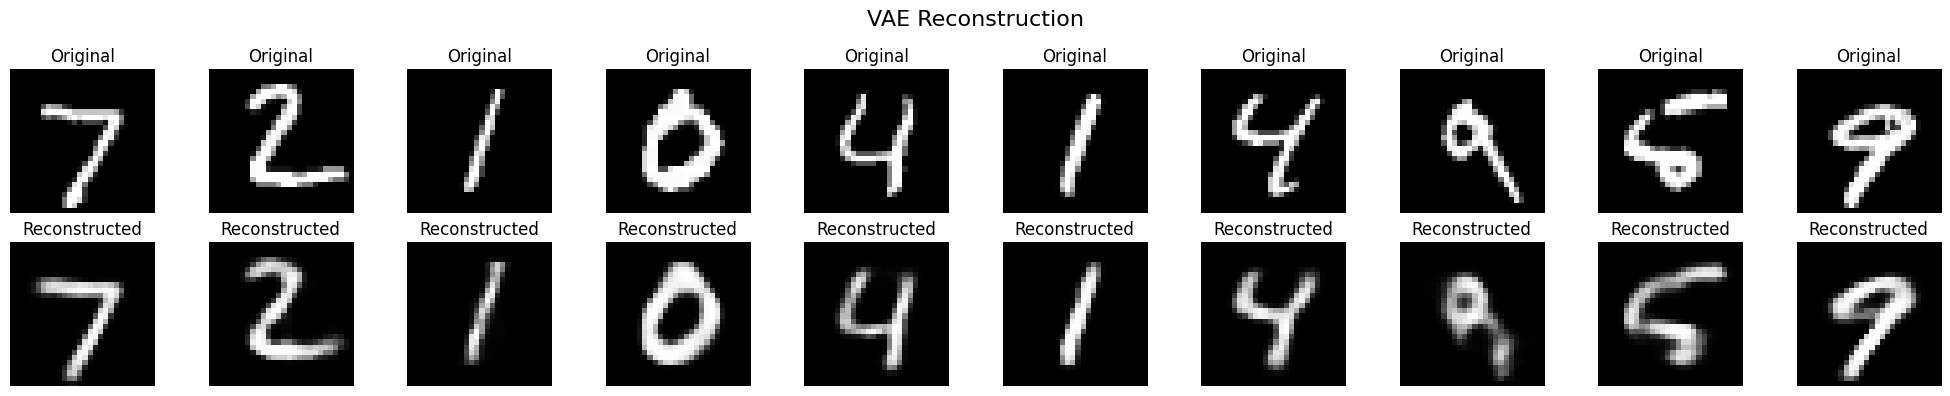

MSE VAE Reconstruction:


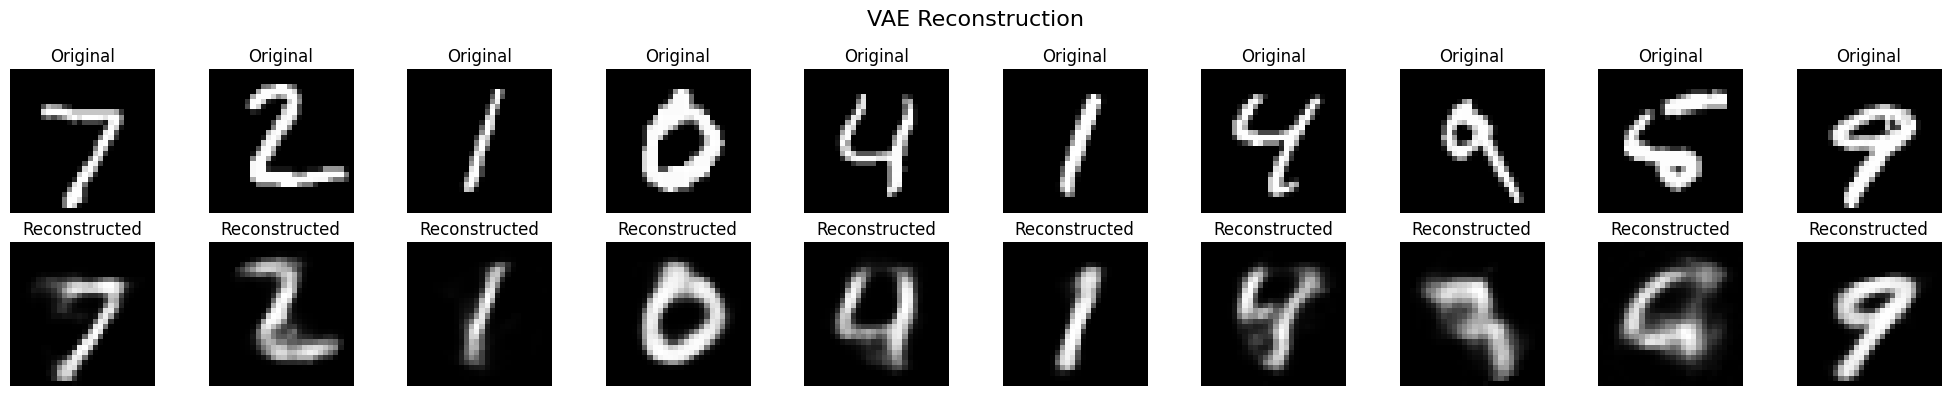

In [3]:
print("BCE VAE Reconstruction:")
plot_reconstruction(model_bce, test_loader)

print("MSE VAE Reconstruction:")
plot_reconstruction(model_mse, test_loader)

Latent space (BCE VAE):


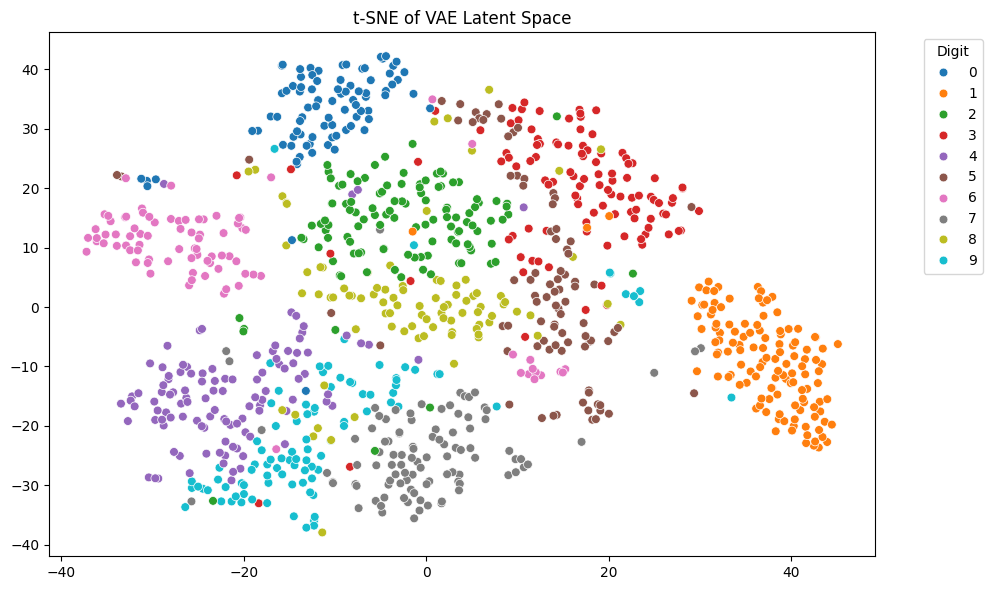

Latent space (MSE VAE):


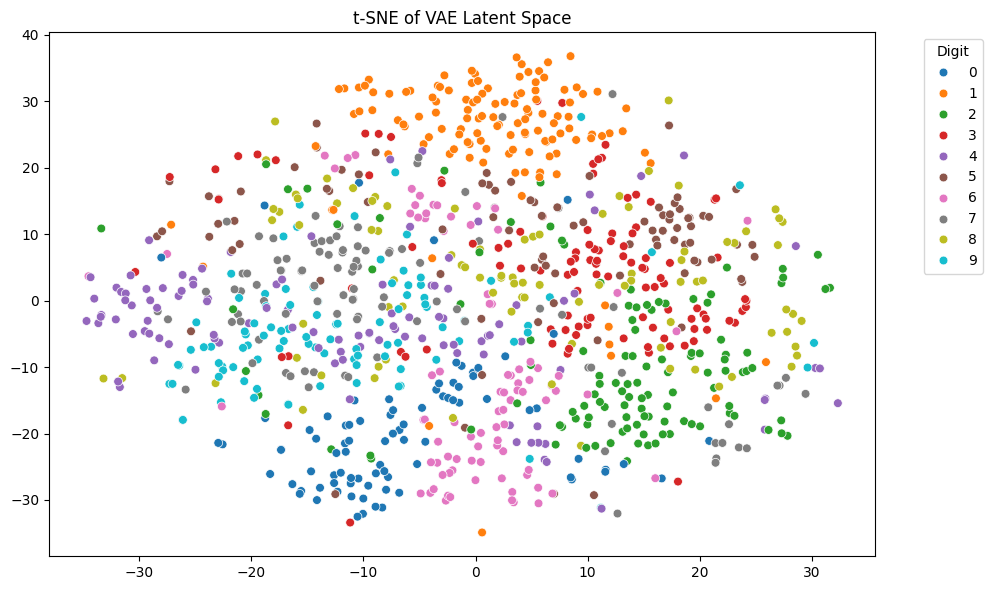

In [5]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

def plot_latent_space(model, data_loader, n_samples=1000):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            mu, logvar = model.encode(x.view(-1, 28*28))
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.append(y.numpy())
            if len(latent_vectors) * x.size(0) >= n_samples:
                break

    z_all = np.concatenate(latent_vectors)[:n_samples]
    y_all = np.concatenate(labels)[:n_samples]

    z_embedded = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(z_all)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=z_embedded[:, 0], y=z_embedded[:, 1], hue=y_all, palette='tab10', s=40)
    plt.title("t-SNE of VAE Latent Space")
    plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot t-SNE for both models
print("Latent space (BCE VAE):")
plot_latent_space(model_bce, test_loader)

print("Latent space (MSE VAE):")
plot_latent_space(model_mse, test_loader)


Latent space (BCE VAE):


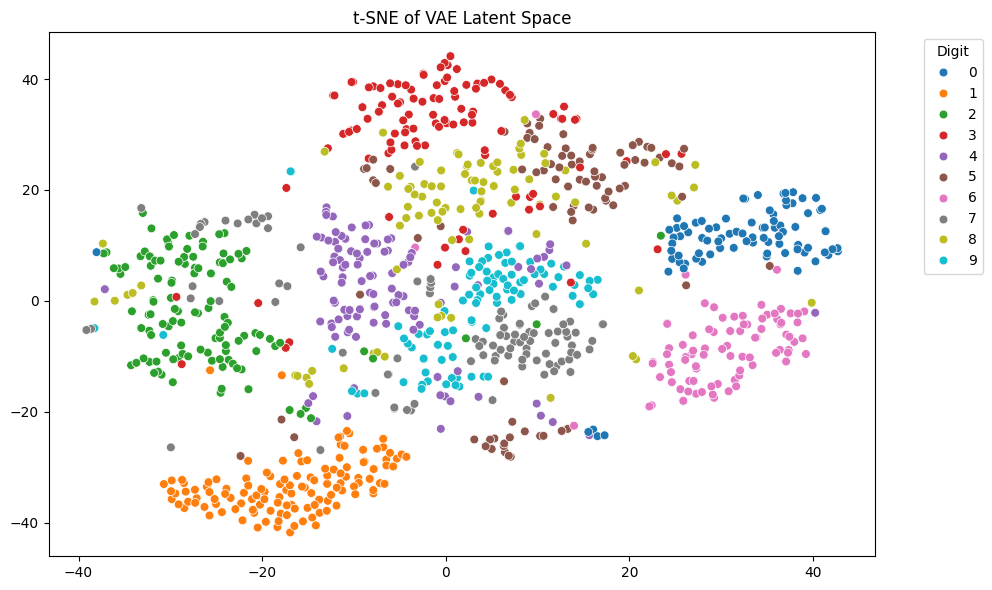

Latent space (MSE VAE):


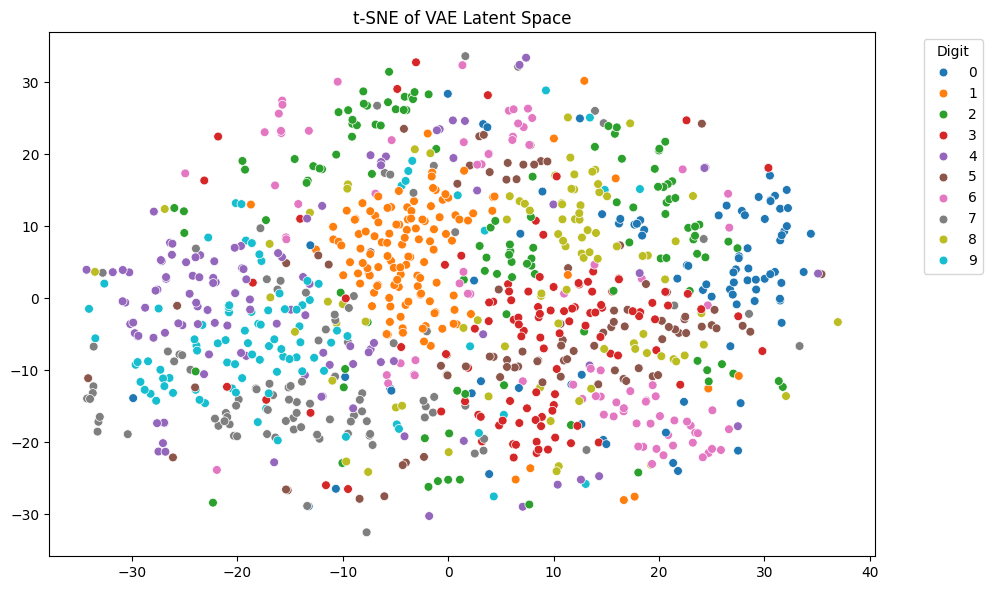

In [6]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

def plot_latent_space(model, data_loader, n_samples=1000):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            mu, logvar = model.encode(x.view(-1, 28*28))
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.append(y.numpy())
            if len(latent_vectors) * x.size(0) >= n_samples:
                break

    z_all = np.concatenate(latent_vectors)[:n_samples]
    y_all = np.concatenate(labels)[:n_samples]

    z_embedded = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(z_all)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=z_embedded[:, 0], y=z_embedded[:, 1], hue=y_all, palette='tab10', s=40)
    plt.title("t-SNE of VAE Latent Space")
    plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot t-SNE for both models
print("Latent space (BCE VAE):")
plot_latent_space(model_bce, test_loader)

print("Latent space (MSE VAE):")
plot_latent_space(model_mse, test_loader)


Latent space (BCE VAE):


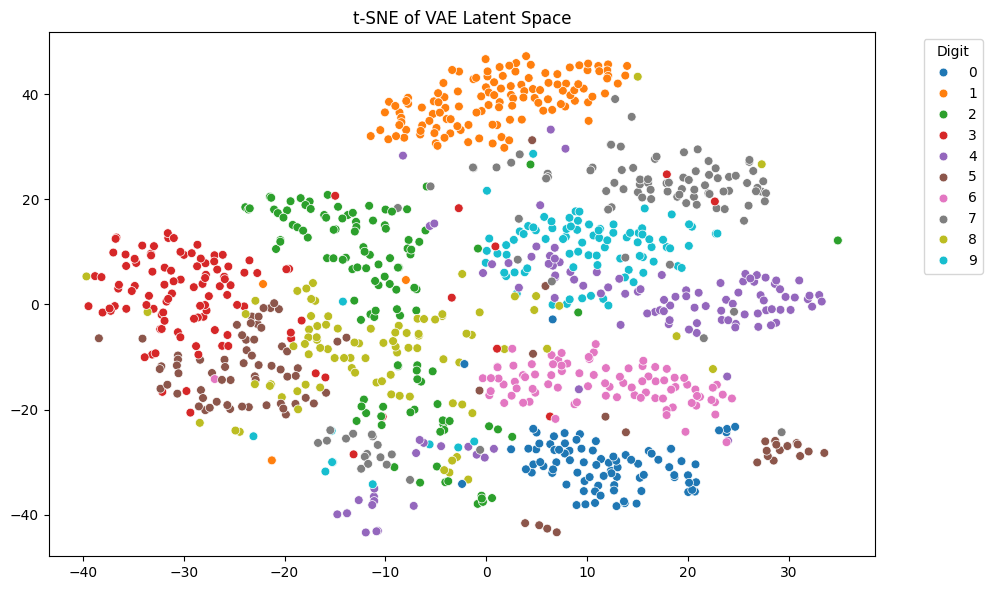

Latent space (MSE VAE):


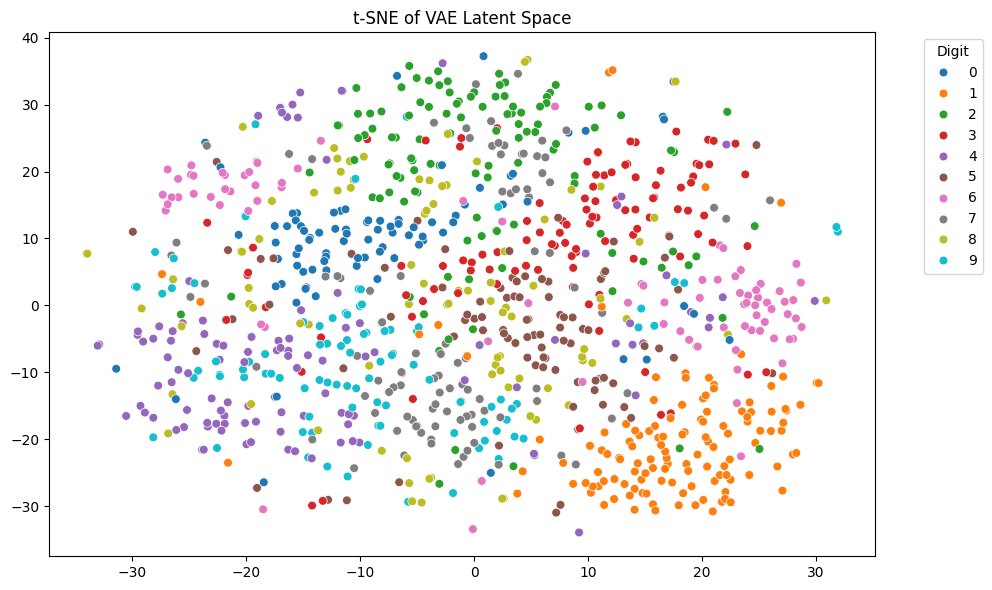

In [7]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

def plot_latent_space(model, data_loader, n_samples=1000):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            mu, logvar = model.encode(x.view(-1, 28*28))
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.append(y.numpy())
            if len(latent_vectors) * x.size(0) >= n_samples:
                break

    z_all = np.concatenate(latent_vectors)[:n_samples]
    y_all = np.concatenate(labels)[:n_samples]

    z_embedded = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(z_all)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=z_embedded[:, 0], y=z_embedded[:, 1], hue=y_all, palette='tab10', s=40)
    plt.title("t-SNE of VAE Latent Space")
    plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot t-SNE for both models
print("Latent space (BCE VAE):")
plot_latent_space(model_bce, test_loader)

print("Latent space (MSE VAE):")
plot_latent_space(model_mse, test_loader)
